### Load in modules

In [1]:
import math
import datetime as dt
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import shapefile as shp
from scipy import stats
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import MeanShift


### Load in shapefiles

In [2]:
uk_map = gpd.read_file('./data/shp/shapefile_out.shp')
uk_map = uk_map.to_crs('epsg:3395')


### Load in MCC node times

In [4]:
tl_mcc_node_times = pd.read_csv('./mcc_node_times/BA.1.15_DTA_102_n2967_mcc_node_times.tsv', sep='\t')
tl_mcc_node_times.head_date = tl_mcc_node_times.head_date.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
tl_mcc_node_times.tail_date = tl_mcc_node_times.tail_date.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
tl_mcc_node_times


,head_node,tail_node,head_date,head_dec_date,tail_date,tail_dec_date
0,1,2,2021-11-22,2021.891508,2021-11-24,2021.896229
1,2,3,2021-11-24,2021.896229,2021-11-28,2021.908479
2,3,4,2021-11-28,2021.908479,2021-11-29,2021.909620
3,4,5,2021-11-29,2021.909620,2021-11-29,2021.910008
4,5,6,2021-11-29,2021.910008,2021-11-29,2021.910182
...,...,...,...,...,...,...
5943,1,5945,2021-11-22,2021.891508,2021-12-07,2021.933217
5944,5945,5946,2021-12-07,2021.933217,2021-12-08,2021.934247
5945,5945,5947,2021-12-07,2021.933217,2021-12-25,2021.981375
5946,5947,5948,2021-12-25,2021.981375,2021-12-30,2021.994521


## Load in MCC geo_summary

In [14]:
tl_mcc_geo = pd.read_csv('./mcc_geo/BA.1.15_DTA_102_n2967_mcc_geo_summary.tsv', sep='\t')
tl_mcc_geo = pd.merge(tl_mcc_geo, tl_mcc_node_times, on=['head_node', 'tail_node'])

tl_mcc_geo = tl_mcc_geo[['head_node', 'tail_node',
                         'head_date', 'tail_date',
                         'head_dec_date', 'tail_dec_date',
                         'head_lat_4326', 'head_long_4326',
                         'tail_lat_4326', 'tail_long_4326', 'geo_distance']]

tl_mcc_geo['head_geometry'] = tl_mcc_geo.apply(lambda row: Point(row.head_long_4326, row.head_lat_4326), axis=1)
tl_mcc_geo['tail_geometry'] = tl_mcc_geo.apply(lambda row: Point(row.tail_long_4326, row.tail_lat_4326), axis=1)

tl_mcc_head_points = tl_mcc_geo[
    ['head_node', 'head_date', 'head_dec_date', 'head_geometry', 'geo_distance']].rename(
    columns={'head_geometry': 'geometry'})
tl_mcc_tail_points = tl_mcc_geo[
    ['tail_node', 'tail_date', 'tail_dec_date', 'tail_geometry', 'geo_distance']].rename(
    columns={'tail_geometry': 'geometry'})


In [15]:
tl_mcc_head_points = gpd.GeoDataFrame(tl_mcc_head_points, crs='epsg:4326')
tl_mcc_head_points = tl_mcc_head_points.to_crs('epsg:3395')
tl_mcc_tail_points = gpd.GeoDataFrame(tl_mcc_tail_points, crs='epsg:4326')
tl_mcc_tail_points = tl_mcc_tail_points.to_crs('epsg:3395')


In [16]:
tl_mcc_head_points['x'] = tl_mcc_head_points.geometry.apply(lambda x: x.x)
tl_mcc_head_points['y'] = tl_mcc_head_points.geometry.apply(lambda x: x.y)

tl_mcc_tail_points['x'] = tl_mcc_tail_points.geometry.apply(lambda x: x.x)
tl_mcc_tail_points['y'] = tl_mcc_tail_points.geometry.apply(lambda x: x.y)


### Extract short-range viral movements

In [17]:
geo_distance_max = 15
tl_mcc_geo_short_range = tl_mcc_geo[tl_mcc_geo.geo_distance < geo_distance_max]
tl_mcc_geo_short_range = tl_mcc_geo_short_range[['head_date', 'tail_date',
                                                 'head_dec_date', 'tail_dec_date',
                                                 'head_lat_4326', 'head_long_4326',
                                                 'tail_lat_4326', 'tail_long_4326', 'geo_distance']]
tl_mcc_geo_short_range['mov_lab'] = [i for i in range(len(tl_mcc_geo_short_range))]

tl_mcc_geo_short_range['head_geometry'] = tl_mcc_geo_short_range.apply(
    lambda row: Point(row.head_long_4326, row.head_lat_4326), axis=1)
tl_mcc_geo_short_range['tail_geometry'] = tl_mcc_geo_short_range.apply(
    lambda row: Point(row.tail_long_4326, row.tail_lat_4326), axis=1)

tl_mcc_geo_short_range_head_points = tl_mcc_geo_short_range[[
    'mov_lab', 'head_date', 'head_dec_date', 'head_geometry']].rename(
    columns={'head_geometry': 'geometry'})
tl_mcc_geo_short_range_tail_points = tl_mcc_geo_short_range[[
    'mov_lab', 'tail_date', 'tail_dec_date', 'tail_geometry']].rename(
    columns={'tail_geometry': 'geometry'})

tl_mcc_geo_short_range_head_points = gpd.GeoDataFrame(tl_mcc_geo_short_range_head_points, crs='epsg:4326')
tl_mcc_geo_short_range_head_points = tl_mcc_geo_short_range_head_points.to_crs('epsg:3395')
tl_mcc_geo_short_range_tail_points = gpd.GeoDataFrame(tl_mcc_geo_short_range_tail_points, crs='epsg:4326')
tl_mcc_geo_short_range_tail_points = tl_mcc_geo_short_range_tail_points.to_crs('epsg:3395')

tl_mcc_geo_short_range_head_points['x'] = tl_mcc_geo_short_range_head_points.geometry.apply(lambda x: x.x)
tl_mcc_geo_short_range_head_points['y'] = tl_mcc_geo_short_range_head_points.geometry.apply(lambda x: x.y)

tl_mcc_geo_short_range_tail_points['x'] = tl_mcc_geo_short_range_tail_points.geometry.apply(lambda x: x.x)
tl_mcc_geo_short_range_tail_points['y'] = tl_mcc_geo_short_range_tail_points.geometry.apply(lambda x: x.y)


In [18]:
tl_mcc_geo_short_range_mid = pd.merge(
    tl_mcc_geo_short_range_head_points[['mov_lab', 'head_date', 'x', 'y']].rename(columns={
        'x': 'head_x',
        'y': 'head_y'
    }),
    tl_mcc_geo_short_range_tail_points[['mov_lab', 'tail_date', 'x', 'y']].rename(columns={
        'x': 'tail_x',
        'y': 'tail_y'
    }),
    on='mov_lab')
tl_mcc_geo_short_range_mid = pd.merge(tl_mcc_geo_short_range_mid,
                                      tl_mcc_geo_short_range[['mov_lab', 'geo_distance']],
                                      on='mov_lab')


In [19]:
tl_mcc_geo_short_range_mid['mid_x'] = tl_mcc_geo_short_range_mid.apply(
    lambda row: (row.head_x + row.tail_x)/2, axis=1)
tl_mcc_geo_short_range_mid['mid_y'] = tl_mcc_geo_short_range_mid.apply(
    lambda row: (row.head_y + row.tail_y)/2, axis=1)
tl_mcc_geo_short_range_mid['mid_date'] = tl_mcc_geo_short_range_mid.apply(
    lambda row: row.head_date + dt.timedelta(days=(row.tail_date - row.head_date).days/2), axis=1)
tl_mcc_geo_short_range_mid = tl_mcc_geo_short_range_mid[[
    'head_date', 'tail_date', 'mid_date', 'geo_distance', 'mid_x', 'mid_y']]


In [20]:
## specify time-window
start_date = dt.datetime.strptime('2021-12-01', '%Y-%m-%d') ## inclusive
end_date = dt.datetime.strptime('2021-12-25', '%Y-%m-%d')

## extract relevant viral lineage movements
tl_mcc_geo_short_range_mid_time_filtered = tl_mcc_geo_short_range_mid[
    (tl_mcc_geo_short_range_mid.mid_date >= start_date) &
    (tl_mcc_geo_short_range_mid.mid_date < end_date)]

## specify bandwidth of meanshift for hotspot identification
m_bw = 100 ## km
m_xys = list(zip(tl_mcc_geo_short_range_mid_time_filtered.mid_x.values,
                 tl_mcc_geo_short_range_mid_time_filtered.mid_y.values))
m_clustering = MeanShift(bandwidth=m_bw*1000).fit(m_xys)

tl_mcc_geo_short_range_hs_plot = gpd.GeoDataFrame(
    [(m_clustering.cluster_centers_[i][0],
      m_clustering.cluster_centers_[i][1],
      m_clustering.labels_.tolist().count(i)) for i in range(len(set(m_clustering.labels_)))],
    columns=['x', 'y', 'freq'])
tl_mcc_geo_short_range_hs_plot['geometry'] = tl_mcc_geo_short_range_hs_plot.apply(
    lambda row: Point(row.x, row.y), axis=1)

print('number of hotspots detected: %d' % len(set(m_clustering.labels_)))


number of hotspots detected: 5


### Plot

In [21]:
tl_mcc_head_points = tl_mcc_head_points.sort_values(by='head_node')
tl_mcc_head_points = tl_mcc_head_points.drop_duplicates(subset=['head_node'], keep='first')


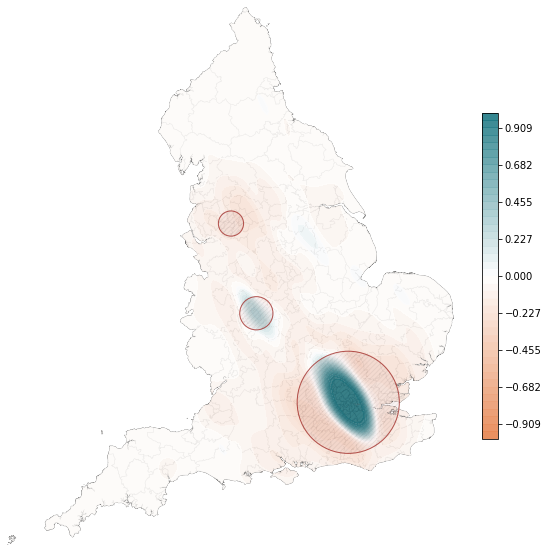

In [29]:
## read shape file
sfile = shp.Reader('./data/smoothed_border_epsg3395/smoothed_border_epsg3395.shp')

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)

Path = mpath.Path
## make clip path
for shape_rec in sfile.shapeRecords():
    vertices = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            vertices.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = mpath.Path(vertices, codes)
    clip = mpatches.PathPatch(clip, transform=ax.transData)

xmin, xmax = uk_map.bounds.minx.min(), uk_map.bounds.maxx.max()
ymin, ymax = uk_map.bounds.miny.min(), uk_map.bounds.maxy.max()

x, y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
pos = np.vstack([x.ravel(), y.ravel()])

bw_smoothing = 0.25
# bw_smoothing = 1
head_data = np.vstack(
    [tl_mcc_head_points[
        (tl_mcc_head_points.head_date >= start_date) & (tl_mcc_head_points.head_date <= end_date) &
        (tl_mcc_head_points.geo_distance >= geo_distance_max)].x,
     tl_mcc_head_points[
        (tl_mcc_head_points.head_date >= start_date) & (tl_mcc_head_points.head_date <= end_date) &
        (tl_mcc_head_points.geo_distance >= geo_distance_max)].y])
head_kernel = stats.gaussian_kde(head_data, bw_method=bw_smoothing)
head_z = np.reshape(head_kernel(pos).T, x.shape)

tail_data = np.vstack(
    [tl_mcc_tail_points[
        (tl_mcc_tail_points.tail_date >= start_date) & (tl_mcc_tail_points.tail_date <= end_date) &
        (tl_mcc_tail_points.geo_distance >= geo_distance_max)].x,
     tl_mcc_tail_points[
        (tl_mcc_tail_points.tail_date >= start_date) & (tl_mcc_tail_points.tail_date <= end_date) &
        (tl_mcc_tail_points.geo_distance >= geo_distance_max)].y])
tail_kernel = stats.gaussian_kde(tail_data, bw_method=bw_smoothing)
tail_z = np.reshape(tail_kernel(pos).T, x.shape)

diff_z = head_z - tail_z
a = 15e-12
for i, t in enumerate(diff_z):
    for j, tt in enumerate(t):
        new_val = (-1 if tt < 0 else 1)*(1 - math.exp(-abs(tt)/a))
        diff_z[i][j] = new_val
        
max_abs_val = np.max(abs(diff_z))
levels = np.linspace(-1, 1, 45)
cmap = LinearSegmentedColormap.from_list("", ["#E6824C", "#ffffff", "#1B7883"])
uk_map.plot(ax=ax, fc='#ededed', ec='#484848', lw=0.5, alpha=0.9)
contour = ax.contourf(x, y, diff_z, 45, vmin=-1, vmax=1, cmap=cmap, levels=levels, alpha=0.9)
plt.colorbar(contour, shrink=0.5)

## draw hotspots
## take only hotspots that account for > 5% of total local fluxes
short_range_fluxes_total = tl_mcc_geo_short_range_hs_plot.freq.sum()
tl_mcc_geo_short_range_hs_plot['propr'] = tl_mcc_geo_short_range_hs_plot.freq.apply(
    lambda x: x/short_range_fluxes_total)
min_hotspots_propr = 0.05
max_hotspots_n = 5
hotspot_scale = 5
tl_mcc_geo_short_range_hs_plot_max_n = tl_mcc_geo_short_range_hs_plot[
    tl_mcc_geo_short_range_hs_plot.propr >= min_hotspots_propr].sort_values(
    'freq', ascending=False).iloc[:max_hotspots_n]
tl_mcc_geo_short_range_hs_plot_max_n.plot(ax=ax,
                                          markersize=tl_mcc_geo_short_range_hs_plot_max_n.freq.values*hotspot_scale,
                                          marker='o', fc='#9e1915', ec='.0', hatch='/////', alpha=0.05)
tl_mcc_geo_short_range_hs_plot_max_n.plot(ax=ax,
                                          markersize=tl_mcc_geo_short_range_hs_plot_max_n.freq.values*hotspot_scale,
                                          marker='o', ec='#9e1915', fc='none', alpha=0.7)

for c in contour.collections:
    c.set_clip_path(clip)   

ax.set_axis_off()

plt.savefig('./viral_lineages_source_sink_%s_%s.pdf' %
            (dt.datetime.strftime(start_date, '%Y-%m-%d'), dt.datetime.strftime(end_date, '%Y-%m-%d')))
